In [1]:
!sudo apt install -y libsndfile1
!pip install numba==0.48
!pip install git+https://github.com/fastaudio/fastaudio.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
     |████████████████████████████████| 3.5MB 8.2MB/s 
     |████████████████████████████████| 20.2MB 1.5MB/s 
ERROR: umap-learn 0.5.0 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.
ERROR: pynndescent 0.5.1 has requirement numba>=0.51.2, but you'll have numba 0.48.0 which is incompatible.
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Cloning https://github.com/fastaudio/fastaudio.git to /tmp/pip-req-build-nk8q6qdy
  Running command git clone -q https://github.com/fastaudio/fastaudio.git /tmp/pip-req-build-nk8q6qdy
     |████████

In [2]:
!pip install timm
!pip install efficientnet_pytorch

     |████████████████████████████████| 245kB 8.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=b5a8c15884b2eb4a3430b69806d36a784253f7c1ddf6f9e2297428260ed9a005
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchaudio
torchaudio.set_audio_backend("sox_io")


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("..")

import librosa as lr
import librosa.display

import soundfile as sf
import io

from pathlib import Path
from tqdm.notebook import tqdm

from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

import fastai
fastai.__version__

'2.1.8'

In [4]:
from google.colab import drive
drive.mount('/content/drive')# You must grant COLAB access to your Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
DATA_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data")
AUDIO_ROOT = Path(DATA_ROOT/"train/")
#TRAIN_AUDIO_ROOT = Path(DATA_ROOT/"fp_samples_long")
TRAIN_AUDIO_ROOT = Path("/content/train")
#TRAIN_AUDIO_ROOT = Path("/content/samples_mixed")
TEST_AUDIO_ROOT = Path(DATA_ROOT/"test")
VAL_AUDIO_ROOT = Path(DATA_ROOT/"val")
df_train = pd.DataFrame([path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
train_folds = np.load(Path(DATA_ROOT/"folds.npy"), allow_pickle=True)
df_test = pd.DataFrame([path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
df = pd.read_csv(Path(DATA_ROOT/"train_fp.csv"))
print(df_train.shape, df_test.shape)
df

(2958, 1) (1992, 1)


,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984
...,...,...,...,...,...,...,...
7776,ffd88cd84,14,1,3.2000,2531.2500,3.7867,5531.2500
7777,ffebe7313,1,1,35.2000,3843.7500,36.0960,5625.0000
7778,fff163132,17,4,22.5547,1312.5000,25.0880,7406.2500
7779,fff163132,14,1,37.0827,2531.2500,37.6693,5531.2500


# Define multi class model

In [86]:
def get_y_fn(x):
  y = str(x).split(".")[0].split('_')[-2]
  return y

FOLD = 0
val_index = train_folds[FOLD]
FOLD = str(FOLD)
val_index.shape

(240,)

## define mixup

In [87]:
!git clone https://github.com/nestordemeure/ManifoldMixupV2.git

fatal: destination path 'ManifoldMixupV2' already exists and is not an empty directory.


In [88]:
%run /content/ManifoldMixupV2/manifold_mixup.py
OutputMixup()

OutputMixup

<Figure size 432x288 with 0 Axes>

## Define db and dls

In [89]:

def random_power(images, power = 1.5, c= 0.7):
    images = images**(torch.rand(1, device="cuda:0")*power + c)
    #print(images.dtype)
    return images

def normalize_mel(melspec):
    melspec -= melspec.min()
    melspec /= melspec.max()
    #print(melspec)
    return melspec

def normalize_image(melspec):
    #normalize
    m = melspec.min(2, keepdim=True)[0].min(3, keepdim=True)[0]
    melspec -= m
    s = melspec.max(2, keepdim=True)[0].max(3, keepdim=True)[0]
    #s = torch.maximum(s, torch.ones_like(s)*1e-7)
    melspec /= s
    #print(melspec)
    return melspec

class Normalize_channel_1(Transform):
  def __init__(self):
    split_idx = None
  def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
    return normalize_image(melspec)

class Normalize_channel_2(Transform):
  def __init__(self):
    split_idx = None
  def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
    return normalize_image(melspec)

class Normalize_channel_3(Transform):
  def __init__(self):
    split_idx = None
  def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
    return normalize_image(melspec)

class PowerSpec(Transform):
    """
    Transform для возведения спектрограммы в степень.
    """
    def __init__(self, power = 2, c = 0.7):
      self.power = power
      self.c = c
      split_idx = None
    def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
      mel = random_power(melspec, self.power, self.c)
      #print(melspec, mel, mel.size())
      return mel

class LowerUpperFreq(Transform):
    """
    Transform для понижения верхних частот.
    """
    def __init__(self, cfg):
      self.cfg = cfg
      split_idx = None
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.5:
        images = images - images.min(dim =2, keepdim=True)[0]
        r = random.randint(self.cfg.n_mels//2,self.cfg.n_mels)
        x = random.random()/2
        #print(r, x, torch.zeros(self.cfg.n_mels-r)-x+1)
        pink_noise = torch.cat((1-torch.arange(r, device="cuda:0")*x/r,
                                               torch.ones(self.cfg.n_mels-r, device="cuda:0")-x)).T

        #pink_noise = np.array([np.concatenate((1-np.arange(r)*x/r,np.zeros(self.hp.n_mels-r)-x+1))]).T
        #print(images.size(), pink_noise.size(), pink_noise)   
        #print(pink_noise, images)
        images = images.movedim(3,2)       

        images = images*pink_noise
        #images = images/(images.max(dim =2, keepdim=True)[0]
        images = images.movedim(3,2)
        #print(images.shape, images)
      return images

class RowNoise(Transform):
    """
    Transform полосового шума.
    """
    def __init__(self, level_noise, cfg):
      self.cfg = cfg
      self.level_noise = level_noise
      self.split_idx = 0
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.9:
        a = int(torch.rand(1, device="cuda:0") * self.cfg.n_mels//2)
        b =  int(torch.min(torch.rand(1, device="cuda:0") * self.cfg.n_mels, a+20))
        images[a:b,:] = images[a:b,:] + (torch.rand((b-a,images.size()[-1]), device="cuda:0")+9.0) * 0.05 * images.mean() * self.level_noise  * (torch.rand(1, device="cuda:0") + 0.3)

        
      return images

In [90]:
class PinkNoise(Transform):
    """
    Transform для розового шума.
    """
    def __init__(self, level_noise, cfg):
      self.level_noise = level_noise
      self.cfg = cfg
      self.split_idx = 0
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.9:
        r = random.randint(1, self.cfg.n_mels)
         #print(r, x, torch.zeros(self.cfg.n_mels-r)-x+1)
        pink_noise = torch.cat((1-torch.arange(r, device="cuda:0")/r,
                                               torch.zeros(self.cfg.n_mels-r, device="cuda:0"))).T

        #pink_noise = np.array([np.concatenate((1-np.arange(r)*x/r,np.zeros(self.hp.n_mels-r)-x+1))]).T
        #print(images.size(), pink_noise.size(), pink_noise)   
       
        images = images + (torch.rand((self.cfg.n_mels,images.size()[-1]), device="cuda:0")+9.0) * 2  * images.mean() * self.level_noise * (torch.rand(1, device="cuda:0") + 0.3)
        #print(pink_noise, images)
        #print(images.shape, images)
      return images

class WhiteNoise(Transform):
    """
    Transform для розового шума.
    """
    def __init__(self, level_noise, cfg):
      self.level_noise = level_noise
      self.cfg = cfg
      self.split_idx = 0
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.9:
        images = images + (torch.rand((self.cfg.n_mels,images.size()[-1]), device="cuda:0")+9.0) * images.mean() * self.level_noise * (torch.rand(1, device="cuda:0") + 0.3)
        #print(images.shape, images)
      return images


In [91]:
class Mono2Color(Transform):
    """
    Transform для создания цветной картинки.
    """
    def __init__(self):
      split_idx = None
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      delta = torchaudio.functional.compute_deltas(images)
      delta2 = torchaudio.functional.compute_deltas(delta)
      colored_image = torch.cat((images, delta, delta2), dim=1)
      #print(colored_image.shape)
      return colored_image

class Mask(Transform):
    """
    Transform для рандомизации MaskFreq и MaskTime.
    """
    def __init__(self):
      split_idx = None
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      rnd = torch.rand(1)
      #print(images[0].shape, images.dtype, rnd, int(rnd*8))
      #if isinstance(images, AudioSpectrogram): 
      if rnd < 0.25:
        images.data = MaskFreq(num_masks=int(rnd*8), size=20)(images) 
        images.data = MaskTime(num_masks=int(rnd*8), size=16)(images)         
      elif rnd < 0.5:
        images.data = MaskFreq(num_masks=int(rnd*4), size=20)(images)
      elif rnd < 0.75:
        images.data = MaskTime(num_masks=int(rnd*4), size=16)(images)

      return images

In [92]:
cfg = AudioConfig.BasicMelSpectrogram(
        mel=True,
  #      to_db = False
        f_min=df["f_min"].min(),
        f_max=df["f_max"].max(),
        # n_fft=1024,
        n_mels=384,
        hop_length=292,
       # n_fft = 892, 
        #hop_length=245, 
        #n_mels = 224,
      #  normalized=True
   )

item_tfms = [Resample(28000),
             ResizeSignal(8000, pad_mode=AudioPadType.Repeat), 
            AddNoise(noise_level=0.05, color=NoiseColor.Pink),
            AddNoise(noise_level=0.05, color=NoiseColor.White),
           ]
batch_tfms = [ AudioToSpec.from_cfg(cfg), 
       #       Normalize_channel(),
       #       PowerSpec(), # увеличение контрастности
       #       TAmplitudeToDB(),
              Normalize_channel_1(),
    #          PowerSpec(1.5, 0.7),
              WhiteNoise(0.005, cfg),
              PinkNoise(0.005, cfg),
       #       RowNoise(0.025, cfg),
              LowerUpperFreq(cfg),
              Normalize_channel_2(),
              PowerSpec(2, 0.7), # увеличение контрастности
      #        Normalize_channel_3(),
              SGRoll(),
              Mask(),
           #   Mono2Color()
         #     Normalize(ch_mean, ch_std, axes=(0, 1, 3)),
              ]
AddNoise.split_idx = 0
Mask.split_idx = 0

SGRoll.split_idx = 0

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_items=get_audio_files,
                 item_tfms = item_tfms,
                 #splitter = IndexSplitter(val_index.tolist()), #report unnesesary transform to list
                 splitter = RandomSplitter(),
                 get_y=get_y_fn,
                 batch_tfms = batch_tfms
                                  )
print(auds.summary(TRAIN_AUDIO_ROOT))
dls = auds.dataloaders(TRAIN_AUDIO_ROOT, bs=16, verbose=True, before_batch = batch_tfms, 
                       num_workers=4
                       #, shuffle=True
                      )


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Setting-up type transforms pipelines
Found 2958 items
2 datasets of sizes 2367,591
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /content/train/57ff372f3_0_427.flac
    applying partial gives
      AudioTensor of size 1x252000
  Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/train/57ff372f3_0_427.flac
    applying get_y_fn gives
      0
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (AudioTensor([[-0.0114,  0.0026,  0.0081,  ...,  0.0244,  0.0128,  0.0086]]), TensorCategory(0))


Found 2958 items
2 datasets of sizes 2367,591
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resample -> DownmixMono -> Res

In [93]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(scores, truth):
    #print(truth.shape, scores.shape)
    num_samples, num_classes = scores.shape
    scores = scores.cpu().numpy()
    gt = np.zeros((num_samples, num_classes))
    for n, i in enumerate(truth.cpu().numpy().astype(int)):
      gt[n, i] = 1
    assert gt.shape == scores.shape
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], gt[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(gt > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    #return per_class_lwlrap, weight_per_class
    return (per_class_lwlrap * weight_per_class).sum()


In [94]:
from efficientnet_pytorch import EfficientNet
from timm import create_model
# from https://colab.research.google.com/github/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb#scrollTo=VXPjDVUlJgCU

In [95]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.

    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()
        self.in_channels=in_features,
        self.out_channels=out_features,

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        #print(x.size())
        x = x.view(-1, 512, 1)
        
        #print(self.att(x).size())
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)

        #return x, norm_att, cla
        #print(x)
        return x

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [96]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained, in_chans=1)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")
body = create_timm_body('tf_efficientnet_b3_ns', pretrained=True)

head = create_head(num_features_model(nn.Sequential(*body.children())) * (2), dls.c, ps=0.4)
head.__setitem__(8, AttBlock(512, 24))
model = nn.Sequential(body, head)

apply_init(model[1], nn.init.kaiming_normal_)
len(model)

2

In [97]:
model

Sequential(
  (0): Sequential(
    (0): Conv2dSame(1, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        

In [98]:
learn = Learner(dls,  model,
           # n_in=1, #<- Only audio specific modification here
        #    loss_func=LabelSmoothingCrossEntropyFlat(),
            cbs = OutputMixup(alpha=0.4),
            metrics=[accuracy, lwlrap],
            )
learn.to_fp16()
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

(None,
 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9'])

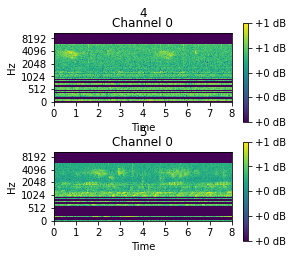

In [99]:
dls.show_batch(), dls.vocab

In [100]:
#learn.lr_find()

In [101]:
wdc wc  

SyntaxError: ignored

In [ ]:
EXP_NAME = "b3_fold" + FOLD 
SUFFIX ="step1"
learn.freeze()
learn.fit(1, 1e-4)
learn.unfreeze()
learn.fit_one_cycle(15, 1e-4, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)])

In [ ]:
SUFFIX ="step2"
#learn.load(EXP_NAME+"_step1")
learn.fit_one_cycle(25, 1e-3/5, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)]
                    )

In [ ]:
SUFFIX ="step3"
#learn.load(EXP_NAME+"_step2")
learn.to_fp16()
learn.fit_one_cycle(25, 1e-3/8, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)]
                    )

## confusion matrix

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

# Predict all classes

In [ ]:
learn.load("b3_fold4_step2", with_opt=False)
learn.remove_cbs(OutputMixup)
learn.cbs

In [ ]:
# !ln -s drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/ol_samples.tar.gz ol_samples.tar.gz  
# !ln -s drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/val  val


In [ ]:
TEST_SAMPLES_AUDIO_ROOT = Path("/content/samples")

#!ln -s drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/val/ /content/val
VAL_AUDIO_ROOT = Path("/content/val")

test_ds = auds.new(VAL_AUDIO_ROOT)
test_dl = learn.dls.test_dl(get_audio_files(TRAIN_AUDIO_ROOT))
#print(test_dl.summary(TEST_TARGET_AUDIO_ROOT))
#test_probas, *_ = learn.tta(dl=test_dl, n=2, use_max=True)
test_probas, *_ = learn.tta(dl=test_dl, n=4, use_max=False, beta=1/3)

In [ ]:
result=[]
for probas, fname in zip(test_probas, test_dl.items):
  print(fname)
  result.append([fname.stem.split("_")[0], fname.stem.split("_")[1], probas.numpy(), fname.stem])
res = pd.DataFrame(result, columns =["recording_id", "part_id", "probas", "fname"])
res["part_id"] = res["part_id"].astype(int)
res.to_csv("all_class_pred_"+FOLD+".csv", columns =["recording_id", "part_id", "probas", "fname"])

In [ ]:
subm = []
for n, row in res.sort_values(by="recording_id").groupby(by="recording_id"):
  a = np.stack(row["probas"].values)
  pred = np.concatenate([np.array(n).reshape(1),
                         np.array(dls.vocab[np.argmax(a.max(axis=0))]).reshape(1),
                         #np.where(a>0.7, a, 0).sum(axis=0)
                         a.max(axis=0)
                         ])
  subm.append(pred)
  #print(n)
  if n == "047a7c4bf":
    #print(row["probas"].max(axis=1))
    cls = np.stack(row["probas"].values).max(axis=0).argsort()
    #print(np.stack(row["probas"].values).argsort())
    #print(dls.vocab[cls[-1]], dls.vocab[cls[-2]], dls.vocab[cls[-3]])
#print(subm)
submission = pd.DataFrame(subm, columns=["recording_id"] + ["top_cat"] + ["s" + i for i in dls.vocab])
submission.head(10)

In [ ]:
submission.drop(["top_cat"], axis=1, inplace=True)
submission.to_csv("subm_29_b3_fold_"+FOLD+".csv", columns=["recording_id"] + ["s" + str(i) for i in range(24)], index=False)

In [ ]:
from sklearn.metrics import accuracy_score
gt=[]
pred=[]
for n, row in submission.iterrows():
  try:
    gr_tr = df[df["recording_id"] == row["recording_id"]]["species_id"].to_numpy()
    if gr_tr.shape[0] > 1:
      if int(row["top_cat"]) in gr_tr:
        gt.append(int(row["top_cat"]))
      else:
        gt.append(gr_tr[0])     
    else: 
      gt.append(gr_tr[0])
    pred.append(int(row["top_cat"]))
  except:
    pass
accuracy_score(gt,pred), len(gt)
#gt, pred

Усредненный сабмит

In [ ]:
subm = []
#subm.append(submission.sort_values(by="recording_id").to_numpy()[:,1:].astype(float))
for i in range(4):
  s = pd.read_csv("subm_29_b3_fold_"+str(i)+".csv")
  subm.append(s.sort_values(by="recording_id").to_numpy()[:,1:])
subm = np.stack(subm)
subm.shape
fs = pd.DataFrame(np.concatenate([submission.sort_values(by="recording_id").to_numpy()[:,0].reshape(-1,1), subm.sum(axis=0)], axis=1),  columns=s.columns)
fs.head()

In [ ]:
fs.to_csv("subm_29_b3_1.csv", index=False)

In [ ]:
res["pred"] = res["probas"].apply(lambda x: dls.vocab[np.argmax(x)])
res["max_prob"] = res["probas"].apply(lambda x: np.max(x))

In [102]:
res[res["max_prob"] > 0.9]

,recording_id,part_id,probas,fname,pred,max_prob
2,59a9eb657,17,"[0.00094842695, 0.00096750486, 0.00044282855, 0.0011481062, 0.004695358, 0.0015000202, 0.0007468573, 0.0032784126, 0.0011282075, 0.00040907259, 0.00044054442, 0.00058144185, 0.0008162195, 0.0007589976, 0.00087304105, 0.0010259204, 0.97207814, 0.0014187975, 0.00030690388, 0.0012144373, 0.0009354463, 0.0013386137, 0.0011796608, 0.0017670171]",59a9eb657_17_2772,23,0.972078
7,59e9a623a,15,"[0.0025061022, 0.0014242617, 0.0013458328, 0.0015422113, 0.9618582, 0.0018395878, 0.0022782155, 0.0015973984, 0.0011570711, 0.00073024345, 0.0040090075, 0.0005682892, 0.00066492666, 0.00185478, 0.0010623062, 0.0017846539, 0.0014816273, 0.002590273, 0.0040221415, 0.0016349172, 0.0011824535, 0.0011296805, 0.000934414, 0.0008013602]",59e9a623a_15_2780,12,0.961858
21,58cb99d6f,5,"[0.002469574, 0.0009783077, 0.0025959986, 0.023853116, 0.0015336442, 0.0011329371, 0.001369622, 0.009348017, 0.00039451325, 0.00091647083, 0.001332633, 0.0009655478, 0.00021422972, 0.0015364668, 0.0012781307, 0.0026880673, 0.0044395616, 0.0007786955, 0.0010913706, 0.0058828397, 0.0006820214, 0.9318346, 0.0005498828, 0.0021337578]",58cb99d6f_5_2741,7,0.931835
33,3cb221dbd,13,"[0.0014975483, 0.00063700567, 0.00027335083, 0.0011642765, 0.00017016483, 0.0012698933, 0.00090648374, 0.97229594, 0.00048737074, 0.00068577885, 0.00043782865, 0.0004497297, 0.00032464784, 0.01592073, 0.000278768, 0.0006857226, 0.0005869912, 0.0003769921, 0.00026156506, 0.00028954053, 0.00029157038, 0.00025014704, 0.00025438317, 0.00020360386]",3cb221dbd_13_1817,15,0.972296
34,3cbb2848e,7,"[0.9940696, 5.5806195e-05, 0.00015162653, 0.00031052824, 0.00012718316, 9.807331e-05, 0.00040456062, 0.000611478, 0.00087424915, 0.00011460046, 2.0686351e-05, 7.5228425e-05, 0.0004054508, 9.956416e-05, 0.00015844264, 0.00019712697, 0.00029937472, 0.0005925568, 0.00036490022, 0.00011761736, 0.00045977038, 0.00024155129, 5.0433304e-05, 9.959467e-05]",3cbb2848e_7_1818,0,0.994070
...,...,...,...,...,...,...
7744,ff5c2d55f,2,"[0.00014967038, 0.00015248028, 9.6118274e-05, 0.00016344547, 0.0011547891, 4.508151e-05, 0.00057107647, 0.0006635669, 0.00017114088, 5.1805473e-05, 0.0013895875, 0.0002937241, 8.8061635e-05, 0.0003287026, 0.00013182359, 9.682716e-05, 0.00042312953, 0.99249214, 6.0895778e-05, 0.0008290506, 0.00014071538, 0.00016901892, 0.00024955743, 8.759728e-05]",ff5c2d55f_2_7748,3,0.992492
7766,fec53d619,1,"[0.0017438971, 0.0024423278, 0.0025559003, 0.0034146376, 0.0007515565, 0.0018692274, 0.00091631786, 0.0024843595, 0.0008517793, 0.005073036, 0.0021903692, 0.0022713563, 0.036426846, 0.0013529845, 0.0005087301, 0.0012314494, 0.00064316555, 0.0005080538, 0.00055852684, 0.0022192607, 0.9265773, 0.0010870097, 0.0014153951, 0.0009064653]",fec53d619_1_7717,6,0.926577
7774,fec53d619,2,"[0.0010385371, 0.0008644905, 0.0034792945, 0.0009955955, 0.0018740683, 0.013598979, 0.0013770593, 0.0073276726, 0.0043663285, 0.0012415093, 0.0021388805, 0.0039394065, 0.0013614714, 0.0030948166, 0.001494177, 0.0018428765, 0.0018003107, 0.00072299736, 0.0018239851, 0.003006565, 0.92816293, 0.004903233, 0.0024152135, 0.007129542]",fec53d619_2_7715,6,0.928163
7777,fe83b6421,22,"[0.0033626708, 0.00039228238, 0.00023062107, 0.000497366, 0.0010566765, 0.00033370344, 0.00012497992, 0.00095184625, 0.00030505596, 0.00020415129, 0.01089381, 0.00014343747, 8.125793e-05, 0.00050584966, 0.00027258167, 0.0003255167, 0.00054220646, 0.9769612, 0.0005297354, 0.00051330955, 0.00011785763, 0.00022184307, 0.0010135343, 0.00041855665]",fe83b6421_22_7709,3,0.976961


In [103]:
import shutil
ld = os.listdir(TRAIN_AUDIO_ROOT)
copy_list = res[res["max_prob"] > 0.9]["fname"].values
for n, row in enumerate(ld):
  
  if Path(row).stem in copy_list:
    shutil.copyfile(TRAIN_AUDIO_ROOT/row, 
                    DATA_ROOT/"fp_part"/(row["recording_id"] + "_" + str(row["pred"]) + "_" + str(n) + ".flac" ))
    print(Path(row).stem)

TypeError: ignored

In [ ]:
!pip install os

In [ ]:
 res["fname"].values

## Вспомогательное


In [ ]:
class MaskFreq(SpectrogramTransform):
    """Google SpecAugment frequency masking from https://arxiv.org/abs/1904.08779."""

    def __init__(self, num_masks=1, size=20, start=None, val=None):
        self.num_masks = num_masks
        self.size = size
        self.start = start
        self.val = val

    def encodes(self, sg: AudioSpectrogram) -> AudioSpectrogram:
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:, None, None]
        mask_val = ifnone(self.val, channel_mean)
        if sg.ndim == 4:
          b, c, y, x = sg.shape
          # Position of the first mask
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x).cuda() * mask_val.cuda()
              mask = mask.view(b, c, self.size, x)
              #print("sg, mask:", sg.shape, mask.shape)
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, :, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        else:
          c, y, x = sg.shape
          # Position of the first msk
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x) * mask_val
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        return sg